# Imports

In [3]:
# !pip install -r requirements.txt

In [1]:
from typing import Tuple, Dict, Callable
import yaml
import pickle
import copy
from datetime import datetime
import numpy as np
import jax.numpy as jnp
from jax import value_and_grad
import jax
import matplotlib.pyplot as plt

import mesher
import bound_cond
import material
import fea
import polygon
import tree
import mma
import utils
import plot_utils


jax.config.update("jax_debug_nans", True)
plt.rcParams.update(plot_utils.high_res_plot_settings)

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
_Ext = utils.Extent
poly_cmap = plot_utils.poly_cmap

In [2]:
# !pip install PyYAML
# !pip install -U jax
# !pip install absl-py
# !pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


# Configs

In [2]:
with open('settings_midcamBeam.yaml', 'r') as file:
  config = yaml.safe_load(file)

cfg_bbox = config['BBOX']
cfg_mesh = config['MESH']
cfg_mat = config['MATERIAL']
cfg_bc = config['BOUNDARY_COND']
cfg_opt = config['OPTIMIZATION']
cfg_quad = config['QUADRIC']
cfg_tree = config['TREE']

# Mesh

In [3]:
bbox = mesher.BoundingBox(x=_Ext(cfg_bbox['x_min'], cfg_bbox['x_max']),
                          y=_Ext(cfg_bbox['y_min'], cfg_bbox['y_max']))
mesh = mesher.BilinearStructMesher(nelx=cfg_mesh['nelx'],
                                   nely=cfg_mesh['nely'],
                                   bounding_box=bbox)

# Material

In [4]:
mat = material.Material(youngs_modulus=cfg_mat['youngs_modulus'],
                        poissons_ratio=cfg_mat['poissons_ratio'],
                        )

# Boundary condition

In [5]:
bc = bound_cond.get_sample_struct_bc(mesh, bound_cond.SturctBCs[cfg_bc['example']])

# Solver

In [6]:
solver = fea.FEA(mesh, mat, bc)

# Init tree

In [7]:
num_levels = cfg_tree['num_levels'] # 6 -> corresponds to 2^6 = 64 base polygons
num_shapes = 2**num_levels
num_operators = 2**num_levels - 1

# Init poly params

In [9]:
poly_ext = polygon.PolygonExtents(
  num_planes_in_a_poly=6,
  num_polys=num_shapes,
  center_x=_Ext(cfg_quad['cx_min'], cfg_quad['cx_max']),
  center_y=_Ext(cfg_quad['cy_min'], cfg_quad['cy_max']),
  angle_offset=_Ext(cfg_quad['th_min'], cfg_quad['th_max']),
  face_offset=_Ext(cfg_quad['a_min'], cfg_quad['a_max']),
)

# Init design var

In [10]:
seed = 0
init_polys = polygon.init_random_polys(poly_ext, seed=seed)

init_prim_des_var = init_polys.to_normalized_array(poly_ext)

num_prim_des_var = init_prim_des_var.shape[0]

# init operators
np.random.seed(seed)
init_operations = np.random.uniform(low=0., high=1., size=(num_operators*4,))
num_oper_des_var = init_operations.shape[0]

init_design_var = np.hstack((init_prim_des_var, init_operations)).reshape((-1, 1))

# Optimizer

In [11]:
class Optimizer:


  def __init__(self,
               lossfn: Callable,
               mesh: mesher.BilinearStructMesher):
    self.lossfn, self.mesh = lossfn, mesh

  def get_poly_params_and_operator_from_design_var(self,
                                                    design_var: jnp.ndarray,
                                                     softmax_temperature: float
                                                     )-> Tuple[polygon.ConvexPolys,
                                                                 jnp.ndarray]:
    
    """
      Computes polygon parameters and operations from the design variables.

      Args:
        design_var : Array representing the design variables.
        softmax_temperature : Temperature parameter for the softmax function that makes the operators more closer to 
                              a one-hot encoding.
      Returns:
        Tuple: A tuple containing the polygon parameters and the operations array.
      """
    poly_des_var = design_var[:num_prim_des_var]
    oper_des_var = design_var[num_prim_des_var:].reshape((num_operators, 4))

    poly_params = polygon.ConvexPolys.from_normalized_array(poly_des_var,
                                                            poly_extents=poly_ext)
    operations = tree.get_operators_from_design_var(oper_des_var,
                                                    t=softmax_temperature)

    return poly_params, operations
  def constraint_fn(self,
                    design_var: jnp.ndarray,
                    max_vol_frac: float
                    ) -> Tuple[jnp.ndarray, jnp.ndarray]:
    
    """
      Computes the volume constraint function for optimization.

      Args:
        design_var: Array representing the design variables: primitive params and operators.
        max_vol_frac : Maximum volume fraction constraint.

      Returns:
        Tuple: A tuple containing the volume constraint value and its gradient.
      """


    def volume_constraint(design_var:jnp.ndarray)-> float:
      softmax_temperature = min(400., 10. + self.mma_state.epoch*5.)
      proj_sharpness = min(12., 1. + self.mma_state.epoch*0.06)

      poly_params, operations = self.get_poly_params_and_operator_from_design_var(
                                                design_var, softmax_temperature)
      poly_sdf = polygon.compute_poly_sdf(poly_params, self.mesh)
      poly_density = polygon.project_sdf_to_density(poly_sdf, self.mesh)
      proj_poly_density = material.projection_filter(poly_density,
                                                        beta=proj_sharpness)
      csg_root = tree.eval_binary_csg_tree(proj_poly_density, operations)
      design_density = material.projection_filter(
                               csg_root.value, beta=proj_sharpness)
      occupied_volume = jnp.einsum('i,i->i',self.mesh.elem_area, design_density).sum()
      volcons =  occupied_volume/(max_vol_frac*self.mesh.domain_volume) - 1.

      return volcons

    vc, dvc = value_and_grad(volume_constraint)(design_var.reshape((-1)))

    return jnp.array([vc]).reshape((-1,1)), dvc.reshape((1,-1))

  def objective_fn(self,
                   design_var: jnp.ndarray
                   )-> Tuple[jnp.ndarray, jnp.ndarray]:
    
    """
      Computes the objective function (complaince) and its gradient for the optimization.

      Args:
        design_var: Array representing the design variables: primitive params and operators.

      Returns:
        Tuple: A tuple containing the objective value (complaince), its gradient, and auxiliary data.
    """

    def obj_wrapper(design_var:jnp.ndarray)-> float:

      softmax_temperature = min(400., 10. + self.mma_state.epoch*5.)
      proj_sharpness = min(12., 1. + self.mma_state.epoch*0.06)
      poly_params, operations = self.get_poly_params_and_operator_from_design_var(
                                                design_var, softmax_temperature)
      poly_sdf = polygon.compute_poly_sdf(poly_params, self.mesh)
      poly_density = polygon.project_sdf_to_density(poly_sdf, self.mesh)
      proj_poly_density = material.projection_filter(poly_density,
                                                        beta=proj_sharpness)
      csg_root = tree.eval_binary_csg_tree(proj_poly_density, operations)
      design_density = material.projection_filter(
                               csg_root.value, beta=proj_sharpness) + 2.e-2
      obj = self.lossfn(design_density.reshape((-1)))
      return obj, (design_density, poly_params, operations, csg_root)

    ((obj,
      (density, poly_params, operations, csg_root)), 
      grad_obj) = value_and_grad(obj_wrapper, has_aux=True
                                              )(design_var.reshape((-1)))
    return jnp.array([obj]), grad_obj.reshape((-1, 1)), (density, poly_params,
                                                         operations, csg_root)


  def optimize(self,
               init_design_var: jnp.ndarray,
               max_vol_frac: float,
               max_iter: int,
               kkt_tol: float=1e-6,
               step_tol: float=1e-6,
               move_limit: float=5e-2,
               plot_interval: int=5,
               )->Tuple[mma.MMAState, Dict]:
    
    """
    Optimize the design using MMA.
    
    Args:
      init_guess: Normalized initial guess for the optimization with values in [0, 1].
      max_vol_frac: Allowable volume fraction.
      max_iter: Number of optimization epochs.
      kkt_tol : Tolerance for the Karush-Kuhn-Tucker condition.
      step_tol : Tolerance for the step size.
      move_limit: Learning rate for the optimization.
      plot_interval: Interval for plotting the design progress.
    
    Returns:
      Tuple containing the final mma state and  convergence history.
    """

    self.num_design_var = init_design_var.shape[0]
    self.design_var = init_design_var
    lower_bound = np.zeros((self.num_design_var, 1))
    upper_bound = np.ones((self.num_design_var, 1))
    mma_params = mma.MMAParams(
        max_iter=max_iter,
        kkt_tol=kkt_tol,
        step_tol=step_tol,
        move_limit=move_limit,
        num_design_var=self.num_design_var,
        num_cons=1,
        lower_bound=lower_bound,
        upper_bound=upper_bound,
    )
    self.mma_state = mma.init_mma(self.design_var, mma_params)

    def plotfun(x, status = ''):
      fig, ax = plt.subplots(1,1)
      plt.imshow(x.reshape((self.mesh.nelx, self.mesh.nely)).T,
                  cmap=poly_cmap, origin='lower')
      ax.set_xticks([])
      ax.set_yticks([])
      plt.title(status)
      plt.show()
    history = {'obj':[], 'vol_cons':[]}

    while not self.mma_state.is_converged:
      objective, grad_obj, (density, poly_params,
                    operations, csg_root) = self.objective_fn(self.mma_state.x)
      constr, grad_cons = self.constraint_fn(self.mma_state.x, max_vol_frac)

      self.mma_state = mma.update_mma(self.mma_state, mma_params,
                                 objective, grad_obj,
                                 constr, grad_cons
                                )
      status = (f'epoch {self.mma_state.epoch:d} obj {objective[0]:.2E} '
                f'vol cons {constr[0,0]:.2E} ')
      history['obj'].append(objective)
      history['vol_cons'].append(constr[0,0])

      print(status)
      if self.mma_state.epoch%plot_interval == 0 or self.mma_state.epoch==1:
        plotfun(density, status)

    density_reshaped = density.reshape((self.mesh.nelx, self.mesh.nely)).T

    return self.mma_state, history, density_reshaped

In [12]:
optim = Optimizer(solver.loss_function, mesh)

epoch 1 obj 3.70E+03 vol cons -9.99E-01 


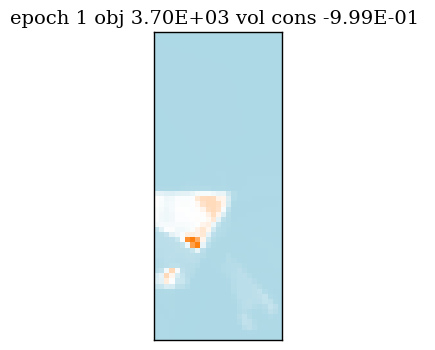

epoch 2 obj 1.41E+01 vol cons 1.56E+00 
epoch 3 obj 3.70E+03 vol cons -1.00E+00 
epoch 4 obj 2.30E+03 vol cons 9.58E-01 
epoch 5 obj 1.13E+03 vol cons -5.08E-01 
epoch 6 obj 6.10E+02 vol cons 1.25E-01 
epoch 7 obj 2.15E+01 vol cons 7.73E-01 
epoch 8 obj 3.68E+03 vol cons -9.96E-01 
epoch 9 obj 1.00E+03 vol cons -4.13E-01 
epoch 10 obj 8.25E+02 vol cons -2.14E-01 


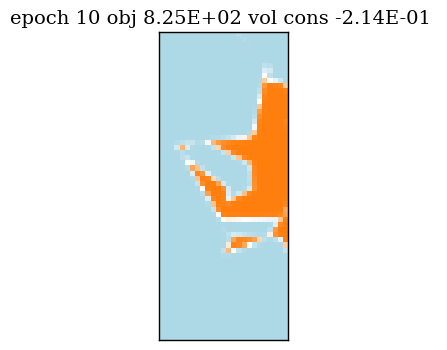

epoch 11 obj 6.89E+02 vol cons -6.56E-02 
epoch 12 obj 6.03E+02 vol cons -9.88E-02 
epoch 13 obj 4.09E+02 vol cons -9.76E-02 
epoch 14 obj 3.14E+02 vol cons -1.31E-01 
epoch 15 obj 1.86E+02 vol cons -1.37E-01 
epoch 16 obj 9.44E+01 vol cons -8.12E-02 
epoch 17 obj 5.51E+01 vol cons -4.91E-02 
epoch 18 obj 4.23E+01 vol cons -2.86E-02 
epoch 19 obj 3.75E+01 vol cons -5.98E-02 
epoch 20 obj 3.11E+01 vol cons -1.13E-02 


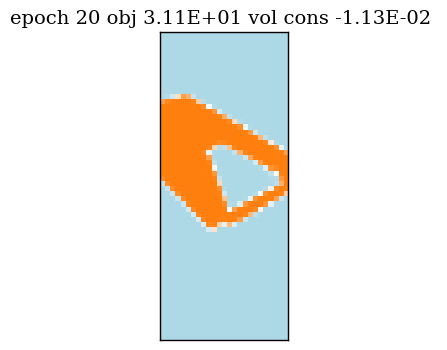

epoch 21 obj 3.27E+01 vol cons -4.33E-02 
epoch 22 obj 2.92E+01 vol cons -2.73E-02 
epoch 23 obj 2.86E+01 vol cons -5.13E-02 
epoch 24 obj 2.60E+01 vol cons -3.30E-02 
epoch 25 obj 2.27E+01 vol cons -6.40E-03 
epoch 26 obj 2.27E+01 vol cons -2.58E-02 
epoch 27 obj 2.12E+01 vol cons -1.06E-02 
epoch 28 obj 2.09E+01 vol cons -3.22E-02 
epoch 29 obj 1.99E+01 vol cons -2.34E-02 
epoch 30 obj 1.99E+01 vol cons -3.05E-02 


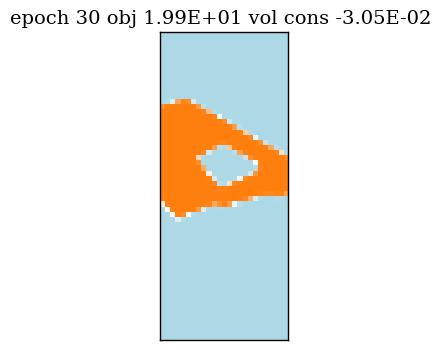

epoch 31 obj 1.92E+01 vol cons -3.75E-02 
epoch 32 obj 1.96E+01 vol cons -2.87E-02 
epoch 33 obj 1.82E+01 vol cons -1.10E-02 
epoch 34 obj 1.91E+01 vol cons -4.95E-02 
epoch 35 obj 1.74E+01 vol cons -3.53E-03 
epoch 36 obj 1.74E+01 vol cons -1.57E-02 
epoch 37 obj 1.63E+01 vol cons -2.40E-03 
epoch 38 obj 1.62E+01 vol cons -1.17E-02 
epoch 39 obj 1.65E+01 vol cons -4.62E-02 
epoch 40 obj 1.73E+01 vol cons -2.60E-02 


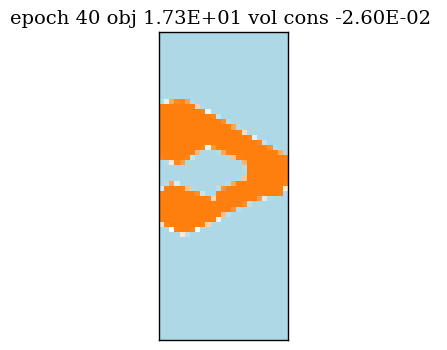

epoch 41 obj 1.89E+01 vol cons -9.27E-02 
epoch 42 obj 1.55E+01 vol cons -3.78E-02 
epoch 43 obj 1.43E+01 vol cons -2.32E-02 
epoch 44 obj 1.37E+01 vol cons -3.02E-02 
epoch 45 obj 1.30E+01 vol cons -2.51E-02 
epoch 46 obj 1.29E+01 vol cons -1.99E-02 
epoch 47 obj 1.29E+01 vol cons -4.74E-02 
epoch 48 obj 1.22E+01 vol cons -1.74E-02 
epoch 49 obj 1.22E+01 vol cons -1.91E-02 
epoch 50 obj 1.24E+01 vol cons -3.47E-02 


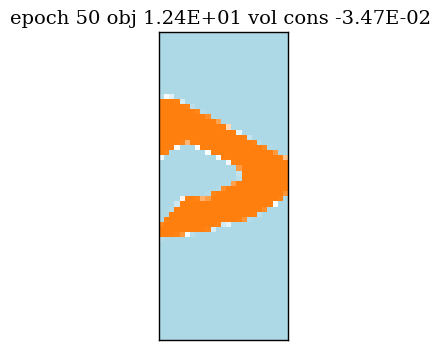

epoch 51 obj 1.17E+01 vol cons -2.11E-02 
epoch 52 obj 1.24E+01 vol cons -3.47E-02 
epoch 53 obj 1.19E+01 vol cons -2.95E-02 
epoch 54 obj 1.18E+01 vol cons -2.43E-02 
epoch 55 obj 1.16E+01 vol cons -2.32E-02 
epoch 56 obj 1.13E+01 vol cons -1.48E-02 
epoch 57 obj 1.14E+01 vol cons -1.94E-02 
epoch 58 obj 1.13E+01 vol cons -4.09E-02 
epoch 59 obj 1.09E+01 vol cons -1.23E-02 
epoch 60 obj 1.09E+01 vol cons -1.56E-02 


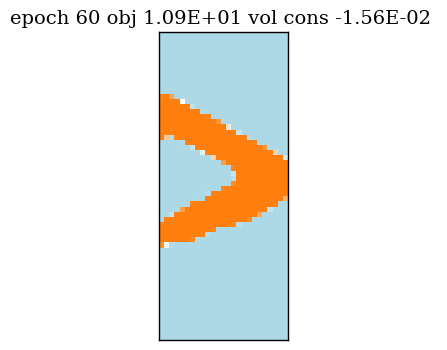

epoch 61 obj 1.06E+01 vol cons -1.20E-02 
epoch 62 obj 1.05E+01 vol cons -3.47E-03 
epoch 63 obj 1.05E+01 vol cons 3.87E-03 
epoch 64 obj 1.05E+01 vol cons -7.18E-03 
epoch 65 obj 1.03E+01 vol cons 1.18E-02 
epoch 66 obj 1.03E+01 vol cons 3.24E-03 
epoch 67 obj 1.03E+01 vol cons 1.12E-02 
epoch 68 obj 1.05E+01 vol cons -1.56E-02 
epoch 69 obj 1.04E+01 vol cons -5.47E-03 
epoch 70 obj 1.03E+01 vol cons 1.26E-02 


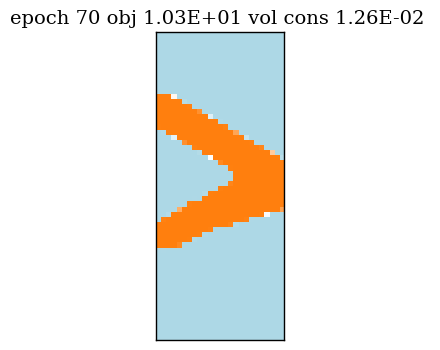

epoch 71 obj 1.06E+01 vol cons -2.05E-02 
epoch 72 obj 1.05E+01 vol cons -1.19E-02 
epoch 73 obj 1.03E+01 vol cons 6.69E-03 
epoch 74 obj 1.04E+01 vol cons -1.09E-02 
epoch 75 obj 1.03E+01 vol cons 2.71E-03 
epoch 76 obj 1.04E+01 vol cons -8.49E-04 
epoch 77 obj 1.04E+01 vol cons -1.78E-03 
epoch 78 obj 1.03E+01 vol cons -4.66E-04 
epoch 79 obj 1.03E+01 vol cons -4.34E-05 
epoch 80 obj 1.04E+01 vol cons -1.25E-03 


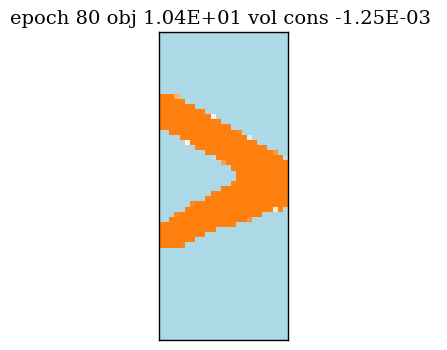

epoch 81 obj 1.04E+01 vol cons -2.33E-03 
epoch 82 obj 1.03E+01 vol cons -9.56E-04 
epoch 83 obj 1.03E+01 vol cons -1.17E-04 
epoch 84 obj 1.03E+01 vol cons -1.13E-04 
epoch 85 obj 1.03E+01 vol cons -9.30E-06 
epoch 86 obj 1.03E+01 vol cons 1.19E-06 
epoch 87 obj 1.03E+01 vol cons -4.23E-06 
epoch 88 obj 1.03E+01 vol cons 1.67E-06 
epoch 89 obj 1.03E+01 vol cons -4.05E-04 
epoch 90 obj 1.03E+01 vol cons -3.58E-05 


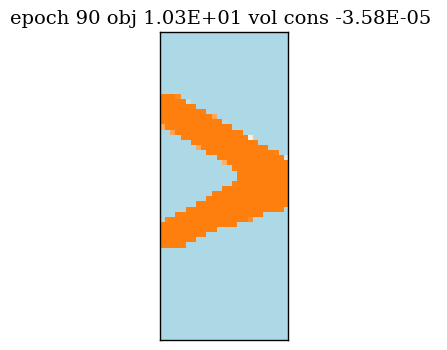

epoch 91 obj 1.03E+01 vol cons -4.45E-05 
epoch 92 obj 1.03E+01 vol cons -5.97E-05 
epoch 93 obj 1.03E+01 vol cons 6.49E-04 
epoch 94 obj 1.04E+01 vol cons -4.41E-03 
epoch 95 obj 1.03E+01 vol cons -9.63E-04 
epoch 96 obj 1.03E+01 vol cons -4.10E-03 
epoch 97 obj 1.03E+01 vol cons -1.50E-03 
epoch 98 obj 1.02E+01 vol cons 1.96E-03 
epoch 99 obj 1.04E+01 vol cons -5.16E-03 
epoch 100 obj 1.03E+01 vol cons -2.09E-03 


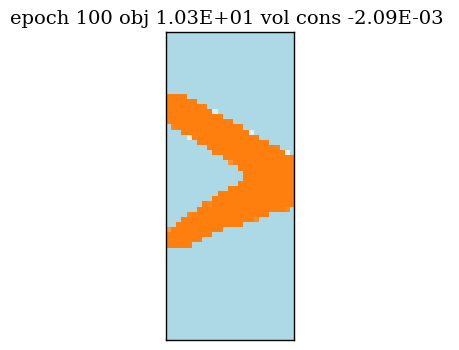

epoch 101 obj 1.03E+01 vol cons -9.99E-04 
epoch 102 obj 1.03E+01 vol cons -2.00E-03 
epoch 103 obj 1.03E+01 vol cons 1.05E-03 
epoch 104 obj 8.58E+00 vol cons 4.66E-01 
epoch 105 obj 9.47E+00 vol cons 3.09E-01 
epoch 106 obj 1.03E+01 vol cons 1.47E-01 
epoch 107 obj 1.11E+01 vol cons 1.27E-02 
epoch 108 obj 1.11E+01 vol cons -4.81E-02 
epoch 109 obj 1.14E+01 vol cons -1.74E-02 
epoch 110 obj 1.07E+01 vol cons 8.03E-03 


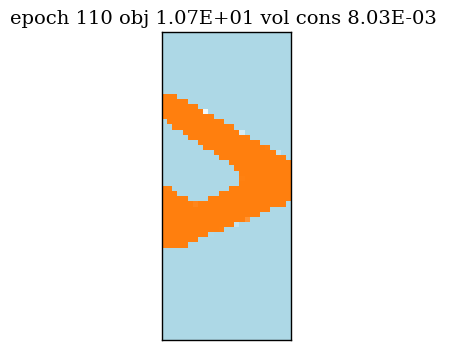

epoch 111 obj 1.08E+01 vol cons -3.89E-02 
epoch 112 obj 1.06E+01 vol cons -1.67E-02 
epoch 113 obj 1.05E+01 vol cons -1.21E-02 
epoch 114 obj 1.04E+01 vol cons 8.71E-04 
epoch 115 obj 1.11E+01 vol cons -5.06E-02 
epoch 116 obj 1.04E+01 vol cons -8.30E-03 
epoch 117 obj 1.06E+01 vol cons -2.38E-02 
epoch 118 obj 1.04E+01 vol cons -1.06E-02 
epoch 119 obj 1.03E+01 vol cons -3.68E-03 
epoch 120 obj 1.03E+01 vol cons -1.85E-03 


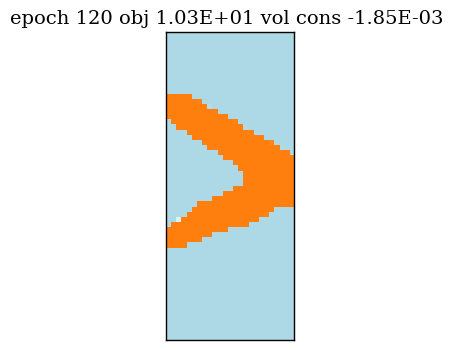

epoch 121 obj 1.04E+01 vol cons -1.54E-02 
epoch 122 obj 1.05E+01 vol cons -2.82E-02 
epoch 123 obj 1.03E+01 vol cons -5.33E-03 
epoch 124 obj 1.02E+01 vol cons 1.09E-02 
epoch 125 obj 1.04E+01 vol cons -1.09E-02 
epoch 126 obj 1.03E+01 vol cons -5.23E-03 
epoch 127 obj 1.02E+01 vol cons 2.66E-03 
epoch 128 obj 1.03E+01 vol cons -3.76E-03 
epoch 129 obj 1.03E+01 vol cons -9.96E-04 
epoch 130 obj 1.03E+01 vol cons -1.07E-03 


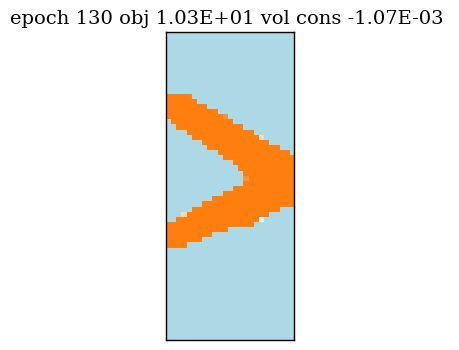

epoch 131 obj 1.03E+01 vol cons -1.10E-03 
epoch 132 obj 1.03E+01 vol cons -4.29E-03 
epoch 133 obj 1.03E+01 vol cons -1.91E-03 
epoch 134 obj 1.03E+01 vol cons -1.01E-03 
epoch 135 obj 1.03E+01 vol cons -8.64E-05 
epoch 136 obj 1.03E+01 vol cons 2.93E-05 
epoch 137 obj 1.03E+01 vol cons 6.38E-05 
epoch 138 obj 1.03E+01 vol cons 8.87E-05 
epoch 139 obj 1.03E+01 vol cons 3.11E-04 
epoch 140 obj 1.03E+01 vol cons 4.72E-05 


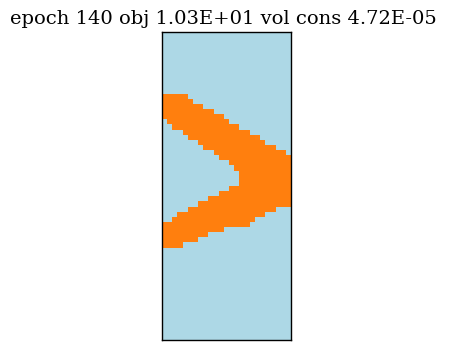

epoch 141 obj 1.03E+01 vol cons 1.04E-05 
epoch 142 obj 1.03E+01 vol cons -7.45E-06 
epoch 143 obj 1.03E+01 vol cons -1.01E-06 
epoch 144 obj 1.03E+01 vol cons -1.07E-06 
epoch 145 obj 1.03E+01 vol cons -8.94E-07 
epoch 146 obj 1.03E+01 vol cons -1.61E-06 
epoch 147 obj 1.03E+01 vol cons 9.54E-07 
epoch 148 obj 1.03E+01 vol cons 3.70E-06 
epoch 149 obj 1.03E+01 vol cons -4.48E-05 
epoch 150 obj 1.03E+01 vol cons -3.82E-05 


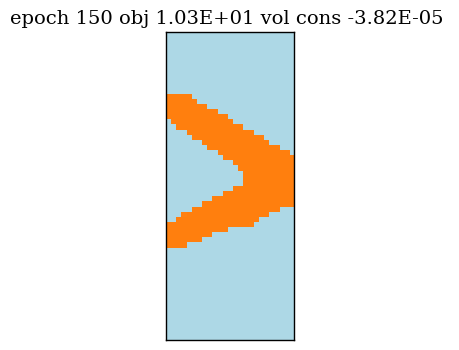

epoch 151 obj 1.03E+01 vol cons -2.10E-05 
epoch 152 obj 1.03E+01 vol cons -8.64E-06 
epoch 153 obj 1.03E+01 vol cons -3.24E-05 
epoch 154 obj 1.03E+01 vol cons -1.91E-05 
epoch 155 obj 1.03E+01 vol cons -1.31E-05 
epoch 156 obj 1.03E+01 vol cons -4.05E-06 
epoch 157 obj 1.03E+01 vol cons -1.78E-03 
epoch 158 obj 1.03E+01 vol cons -7.18E-04 
epoch 159 obj 1.03E+01 vol cons -2.91E-04 
epoch 160 obj 1.03E+01 vol cons -1.18E-04 


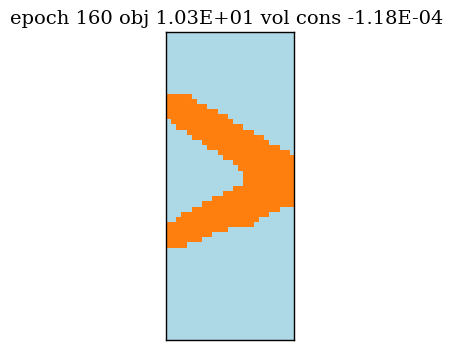

epoch 161 obj 1.03E+01 vol cons -5.08E-05 
epoch 162 obj 1.03E+01 vol cons -2.98E-05 
epoch 163 obj 1.03E+01 vol cons -2.13E-04 
epoch 164 obj 1.03E+01 vol cons -1.08E-04 
epoch 165 obj 1.03E+01 vol cons -4.18E-05 
epoch 166 obj 1.03E+01 vol cons -2.26E-05 
epoch 167 obj 1.03E+01 vol cons -3.77E-04 
epoch 168 obj 1.03E+01 vol cons -1.56E-04 
epoch 169 obj 1.03E+01 vol cons -6.35E-05 
epoch 170 obj 1.03E+01 vol cons -2.30E-05 


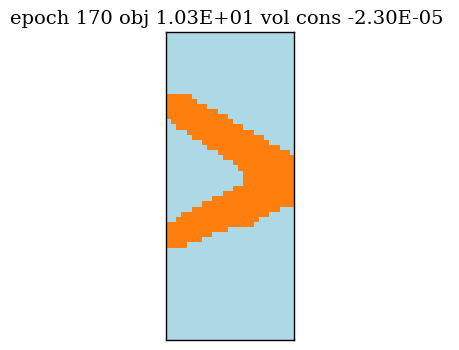

epoch 171 obj 1.03E+01 vol cons -6.50E-06 
epoch 172 obj 1.03E+01 vol cons -2.68E-06 
epoch 173 obj 1.03E+01 vol cons -1.91E-06 
epoch 174 obj 1.03E+01 vol cons -2.81E-05 
epoch 175 obj 1.03E+01 vol cons -2.01E-05 
epoch 176 obj 1.03E+01 vol cons -1.07E-05 
epoch 177 obj 1.03E+01 vol cons -3.70E-06 
epoch 178 obj 1.03E+01 vol cons -4.53E-06 
epoch 179 obj 1.03E+01 vol cons -2.80E-06 
epoch 180 obj 1.03E+01 vol cons -3.34E-06 


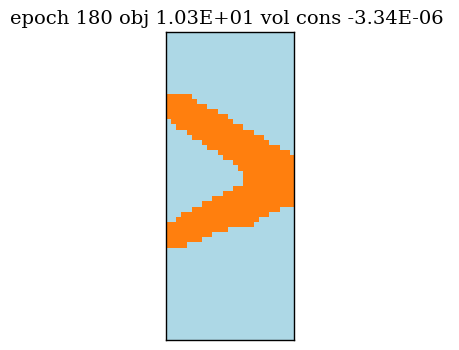

epoch 181 obj 1.03E+01 vol cons -1.19E-07 
epoch 182 obj 1.03E+01 vol cons -3.81E-06 
epoch 183 obj 1.03E+01 vol cons -8.34E-07 
epoch 184 obj 1.03E+01 vol cons -2.50E-06 
epoch 185 obj 1.03E+01 vol cons 0.00E+00 
epoch 186 obj 1.03E+01 vol cons -3.34E-06 
epoch 187 obj 1.03E+01 vol cons -1.19E-06 
epoch 188 obj 1.03E+01 vol cons -1.19E-06 
epoch 189 obj 1.03E+01 vol cons 2.38E-07 
epoch 190 obj 1.03E+01 vol cons -1.32E-04 


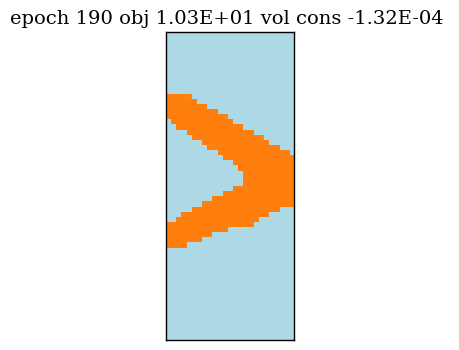

epoch 191 obj 1.03E+01 vol cons -5.59E-05 
epoch 192 obj 1.03E+01 vol cons -2.41E-05 
epoch 193 obj 1.03E+01 vol cons -1.01E-05 
epoch 194 obj 1.03E+01 vol cons -5.01E-06 
epoch 195 obj 1.03E+01 vol cons -1.22E-05 
epoch 196 obj 1.03E+01 vol cons -6.73E-04 
epoch 197 obj 1.03E+01 vol cons -2.60E-04 
epoch 198 obj 1.03E+01 vol cons -1.08E-04 
epoch 199 obj 1.03E+01 vol cons -5.59E-05 
epoch 200 obj 1.03E+01 vol cons -2.89E-04 


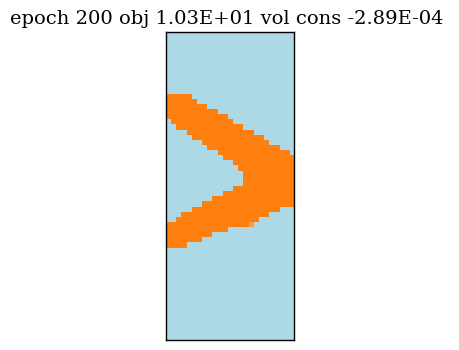

In [13]:
(mma_state, history, density_reshaped) = optim.optimize(
                                    np.array(init_design_var),
                                    max_vol_frac=cfg_opt['desired_vol_frac'],
                                    max_iter=cfg_opt['num_epochs'],
                                    move_limit=cfg_opt['learning_rate'],
                                    plot_interval=cfg_opt['plot_interval']
                                    )

In [15]:
np.save("density_reshaped_DISTRIBUTED_LOAD.npy", density_reshaped)

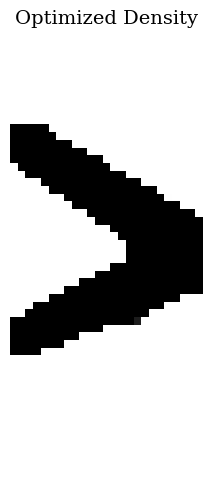

In [14]:
# density_reshaped.shape

plt.figure(figsize=(8, 6))
plt.imshow(1- density_reshaped, cmap='gray', origin='lower')
plt.title("Optimized Density")
plt.axis("off")
plt.show()


In [18]:
dofs=np.arange(mesh.num_dofs)
fixed = dofs[0:2*(mesh.nely+1):1]

print(fixed)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61]


In [17]:
fixed= np.union1d(np.arange(0,2*(mesh.nely+1),2),
                      mesh.num_dofs-2*(mesh.nely+1)+1)

print(fixed)

[   0    2    4    6    8   10   12   14   16   18   20   22   24   26
   28   30   32   34   36   38   40   42   44   46   48   50   52   54
   56   58   60 5581]


In [24]:
mesh.nely

30

In [25]:
dofs[2*(mesh.nely+1)-1::2*(mesh.nely+1)]

array([  61,  123,  185,  247,  309,  371,  433,  495,  557,  619,  681,
        743,  805,  867,  929,  991, 1053, 1115, 1177, 1239, 1301, 1363,
       1425, 1487, 1549, 1611, 1673, 1735, 1797, 1859, 1921, 1983, 2045,
       2107, 2169, 2231, 2293, 2355, 2417, 2479, 2541, 2603, 2665, 2727,
       2789, 2851, 2913, 2975, 3037, 3099, 3161, 3223, 3285, 3347, 3409,
       3471, 3533, 3595, 3657, 3719, 3781, 3843, 3905, 3967, 4029, 4091,
       4153, 4215, 4277, 4339, 4401, 4463, 4525, 4587, 4649, 4711, 4773,
       4835, 4897, 4959, 5021, 5083, 5145, 5207, 5269, 5331, 5393, 5455,
       5517, 5579, 5641])

# Dump/load files

In [ ]:
def save():
  now = datetime.now()
  save_file = f"./results/treetop_{now:%Y-%m-%d-%H-%M}"

  with open(str(save_file) + "_hist.pkl", 'wb') as f:
    pickle.dump(history, f)
  np.save(str(save_file) + "_mma_state.npy", mma_state.to_array())

# save()

In [ ]:
# load_file = "./results/treetop_2024-08-16-22-13"
# mma_state_np = np.load(str(load_file) + "_mma_state.npy")
# mma_state = mma.MMAState.from_array(mma_state_np,
#                                      num_design_var=init_design_var.shape[0])
# with open(str(load_file) + "_hist.pkl", "rb") as f:
#   history = pickle.load(f)

# High resolution plot

In [ ]:
poly_params, operations = optim.get_poly_params_and_operator_from_design_var(mma_state.x, 
                                                                             1000.)

high_res = 3
high_res_mesh = mesher.BilinearStructMesher(nelx=high_res*mesh.nelx,
                                            nely=high_res*mesh.nely,
                                            bounding_box=bbox)
poly_sdf = polygon.compute_poly_sdf(poly_params, high_res_mesh)
poly_density = polygon.project_sdf_to_density(poly_sdf, high_res_mesh, sharpness=10.)
proj_poly_density = material.projection_filter(poly_density, beta=13.)
csg_root = tree.eval_binary_csg_tree(proj_poly_density, operations)
design_density = material.projection_filter(csg_root.value,
                                            beta = 13.)
print(design_density.shape)

In [ ]:
plt.figure()
plt.imshow(np.round(design_density).reshape((high_res_mesh.nelx, high_res_mesh.nely)).T,
            cmap=poly_cmap, origin='lower')
plt.axis('off')
plt.savefig('mbb_validation.svg')
plt.show()

# Recover the poly params, operations and tree from the final state

In [ ]:
pruned_csg_root = copy.deepcopy(csg_root)
tree.prune_tree(pruned_csg_root)

In [ ]:
labels = [rf'X \cap Y', rf'X \cup Y', rf'X \backslash Y', rf'Y \backslash X']

plot_induvidual = False
plot_tree = False
for depth in range(1, num_levels+1):
  nodes = tree.breadth_first_search_at_depth(pruned_csg_root, depth)
  
  opers = []
  for node in nodes:
    if node.operation is not None:
      opers.append(labels[np.argmax(node.operation)])
    else:
      opers.append('\;') # handle leaf nodes
  if len(nodes) == 0:
    continue

  if plot_tree:
    fig, axes = plt.subplots(1, len(nodes), figsize=(len(nodes)*5, 5))
    for i, node in enumerate(nodes):
      if node.is_redundant:
        value = np.zeros_like(node.value)
      else:
        value = node.value
      axes[i].imshow(np.round(value).reshape((high_res_mesh.nelx, high_res_mesh.nely)).T,
                      cmap=poly_cmap, origin='lower', vmin=0., vmax=1.)
      axes[i].set_xticks([])
      axes[i].set_yticks([])
      axes[i].set_xlabel(f'${opers[i]}$', fontname='Times New Roman')
    fig.savefig(f'./results/depth_{depth}.pdf')
  if plot_induvidual:
    for i, node in enumerate(nodes):
      if node.is_redundant:
        value = np.zeros_like(node.value)
      else:
        value = node.value
      infig, inax = plt.subplots(1, 1, figsize=(5, 5))
      inax.imshow(np.round(value).reshape((high_res_mesh.nelx, high_res_mesh.nely)).T,
                  cmap=poly_cmap, origin='lower', vmin=0., vmax=1.)
      inax.set_xticks([])
      inax.set_yticks([])
      infig.savefig(f'./results/depth_{depth}_node_{i}.pdf', bbox_inches='tight',
                    pad_inches=0, transparent=True)